In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA
from sklearn.metrics import silhouette_score

import sys # the basemap visualisation raises future warnings from matplotlib
import warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Import and Prep Data

In [3]:
steam = pd.read_csv('datafiles/steam-200k.csv',
                     names = ['user_id','game','behaviour','hours','blank'],
                     usecols = ['user_id','game','behaviour','hours'])
steam['behaviour'] = steam['behaviour'].replace(to_replace = {'purchase':'1','play':'0'}) # convert booleans
steam['behaviour'] = steam['behaviour'].astype(int)

In [4]:
steam.head()

,user_id,game,behaviour,hours
0,151603712,The Elder Scrolls V Skyrim,1,1.0
1,151603712,The Elder Scrolls V Skyrim,0,273.0
2,151603712,Fallout 4,1,1.0
3,151603712,Fallout 4,0,87.0
4,151603712,Spore,1,1.0


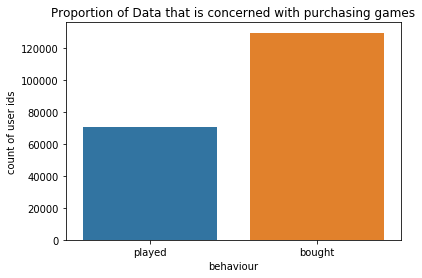

In [5]:
plt.figure(num = 'bought vs played')
plt.title('Proportion of Data that is concerned with purchasing games')
sns.barplot(x = ['played','bought'], y = steam.groupby('behaviour')['user_id'].count());
plt.ylabel("count of user ids");
plt.xlabel("behaviour"); # most of this dataset is concerned with purchasing games, not playing free ones

### Exclude unpopular players, games, and data about playing free games

In [6]:
# # restrict to people who bought games - we're only interested in the behaviour of spending money on games
bought = steam[steam['behaviour'] == 1].copy()
bought = bought.drop(['behaviour','hours'], axis = 1)

games = pd.DataFrame(data = steam[steam['behaviour'] == 0].groupby('game')['hours'].sum())
games = games.reset_index()
games = games.sort_values('hours', ascending = False)

nplayers = bought['user_id'].nunique()
ngames = bought['game'].nunique()

4125 games have less than 25 players, and will be excluded


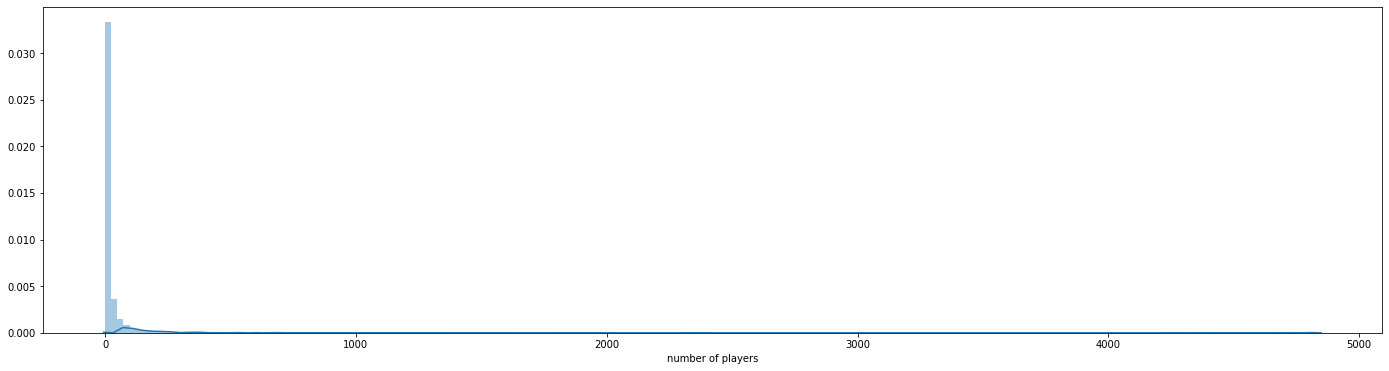

In [7]:
# how many games are barely bought?
gamesbought = pd.DataFrame(bought.groupby('game')['user_id'].count())
gamesbought = gamesbought.reset_index()
gamesbought.columns = ['game','number of players']
gamesbought = gamesbought.sort_values('number of players', ascending = False)

plt.figure(num = 'number of buyers', figsize = (24,6))
sns.distplot(gamesbought['number of players'],bins = 200);

fewplayers = len(gamesbought[gamesbought['number of players'] < 25])
print(str(fewplayers)+" games have less than 25 players, and will be excluded")

fewplayers = pd.DataFrame(gamesbought[gamesbought['number of players'] < 25])
fewplayers = set(fewplayers['game'])

8632 players have less than 5 games, and will be excluded


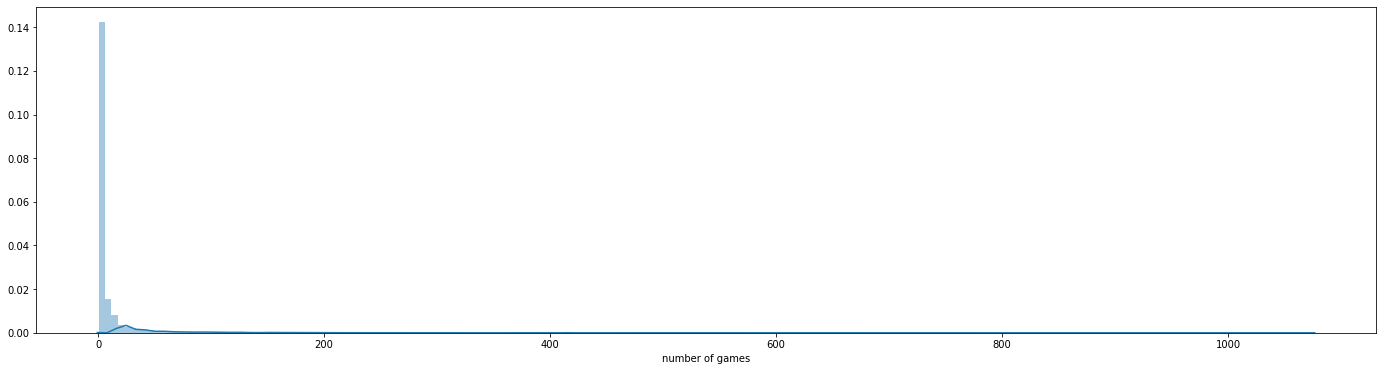

In [8]:
# how many players are buying very few games?
playersbuying = pd.DataFrame(bought.groupby('user_id')['game'].count())
playersbuying = playersbuying.reset_index()
playersbuying.columns = ['user_id','number of games']
playersbuying = playersbuying.sort_values('number of games', ascending = False)

plt.figure(num = 'number of games', figsize = (24,6))
sns.distplot(playersbuying['number of games'], bins = 200);

fewgames = len(playersbuying[playersbuying['number of games'] < 5])
print(str(fewgames)+" players have less than 5 games, and will be excluded")

fewgames = pd.DataFrame(playersbuying[playersbuying['number of games'] < 5])
fewgames = set(fewgames['user_id'])

In [9]:
bought = bought[bought['game'].isin(fewplayers) == False]
bought = bought[bought['user_id'].isin(fewgames) == False]

In [10]:
print("players have been reduced from "+str(nplayers)+" to "+str(bought['user_id'].nunique())+" unique players")
print("games have been reduced from "+str(ngames)+" to "+str(bought['game'].nunique())+" unique games")

players have been reduced from 12393 to 3752 unique players
games have been reduced from 5155 to 1030 unique games


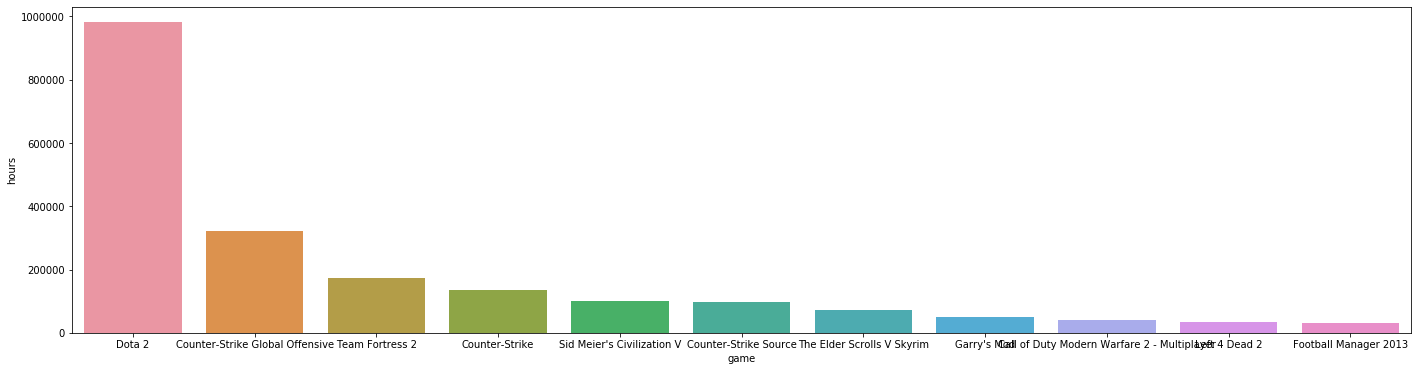

In [11]:
plt.figure(num = 'top games', figsize = (24,6))
sns.barplot(x = games['game'][:11], y = games['hours'][:11]);

### find optimal number of clusters

In [12]:
# convert to matrix = each row is a user_id, eachcolumn is a game, with a 1 indicating that the player played this game
matrix = pd.get_dummies(bought, columns = ['game'])

In [22]:
for i in range(5,26,5):
#     i = 6
    clf = KMeans(n_clusters = i, random_state = 42, n_jobs = 1)
    preds = clf.fit_predict(matrix)
    s = silhouette_score(matrix, preds)
    print(f"sillhouette score is {round(s,4)} with {i} clusters")

sillhouette score is 0.5566 with 5 clusters
sillhouette score is 0.5594 with 10 clusters
sillhouette score is 0.5524 with 15 clusters
sillhouette score is 0.5538 with 20 clusters
sillhouette score is 0.551 with 25 clusters


In [ ]:
# there isn't a lot of variance in the silhouette score - i would expect this will be helped by increasing the number of
# players beyond 9K